## Import libraries

In [31]:
import pandas as pd
import numpy as np

import os #library in managing directories

#for text pre-processing
import nltk #natural language tool kit
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re, string #library in removing special characters
nltk.download('punkt')
nltk.download('stopwords')

#Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#word embedding
from gensim.models import Word2Vec

#train-test, models, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacklynjoaquin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacklynjoaquin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the Dataset

In [2]:
imdb_data = pd.read_csv('/Users/jacklynjoaquin/Documents/IMDB-project/imdb_data_extended.csv')
print(imdb_data.head())
print(imdb_data.tail())

      id                                               text label  rating
0   4715  For a movie that gets no respect there sure ar...   pos       9
1  12390  Bizarre horror movie filled with famous faces ...   pos       8
2   8329  A solid, if unremarkable film. Matthau, as Ein...   pos       7
3   9063  It's a strange feeling to sit alone in a theat...   pos       8
4   3092  You probably all already know this by now, but...   pos      10
          id                                               text label  rating
49995  11513  With actors like Depardieu and Richard it is r...   neg       1
49996   5409  If you like to get a couple of fleeting glimps...   neg       1
49997  11187  When something can be anything you want it to ...   neg       1
49998   9359  I had heard good things about "States of Grace...   neg       3
49999  11556  Well, this movie actually did have one redeemi...   neg       1


In [3]:
print(imdb_data.dtypes)
print("Data shape: ", imdb_data.shape)

id         int64
text      object
label     object
rating     int64
dtype: object
Data shape:  (50000, 4)


In [4]:
imdb_data['text'][4000]

"I'm a fan of Crash and Blade Runner and this movie explores some of those highway death and 80s film noir themes that I like to see, so I enjoyed it.<br /><br />In general though, the essential stupidity of the film noir protagonist is not pulled off well by the female lead and her hero is nearly a neanderthal, hence the kitch warning."

## Text Pre-processing

In [5]:
#text tokenizing
imdb_data['processed'] = imdb_data['text'].apply(lambda x: nltk.word_tokenize(x))
print(imdb_data)


          id                                               text label  rating   
0       4715  For a movie that gets no respect there sure ar...   pos       9  \
1      12390  Bizarre horror movie filled with famous faces ...   pos       8   
2       8329  A solid, if unremarkable film. Matthau, as Ein...   pos       7   
3       9063  It's a strange feeling to sit alone in a theat...   pos       8   
4       3092  You probably all already know this by now, but...   pos      10   
...      ...                                                ...   ...     ...   
49995  11513  With actors like Depardieu and Richard it is r...   neg       1   
49996   5409  If you like to get a couple of fleeting glimps...   neg       1   
49997  11187  When something can be anything you want it to ...   neg       1   
49998   9359  I had heard good things about "States of Grace...   neg       3   
49999  11556  Well, this movie actually did have one redeemi...   neg       1   

                           

In [6]:
#stop word, white space, special character removal, contraction expansion, lowercase transformation

stop_words = stopwords.words('english')
new_stopwords = ["would","shall","could","might", 'br']
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words = set(stop_words)

def remove_special_char(text):
    clean_text = re.sub(r'[^a-zA-Z\s]','', text)
    return clean_text

def remove_stopwords(text):
    clean_data = []
    for i in text.split():
        if i.strip().lower() not in stop_words and i.strip().lower().isalpha():
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)

def expand_contractions(text):
    contractions_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "would've": "would have",
    "should've": "should have",
    "hasn't": "has not",
    "haven't": "have not",
    "wasn't": "was not",
    "weren't": "were not",
    "we're": "we are",
    "didn't": "did not",
    "don't": "do not" }

    # Regular expression pattern to find contractions
    contractions_pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')

    def replace(match):
        return contractions_dict[match.group(0)]

    # Use regular expression to find and replace contractions
    expanded_text = contractions_pattern.sub(replace, text)

    return expanded_text


def data_cleaning(text):
    text = expand_contractions(text)
    text = remove_special_char(text)
    text = remove_stopwords(text)
    return text


imdb_data['processed'] = imdb_data['processed'].apply(lambda x: ' '.join(x))
imdb_data['processed'] = imdb_data['processed'].apply(lambda x: data_cleaning(x))
print(imdb_data.head(), imdb_data.tail())


      id                                               text label  rating   
0   4715  For a movie that gets no respect there sure ar...   pos       9  \
1  12390  Bizarre horror movie filled with famous faces ...   pos       8   
2   8329  A solid, if unremarkable film. Matthau, as Ein...   pos       7   
3   9063  It's a strange feeling to sit alone in a theat...   pos       8   
4   3092  You probably all already know this by now, but...   pos      10   

                                           processed  
0  movie gets respect sure lot memorable quotes l...  
1  bizarre horror movie filled famous faces stole...  
2  solid unremarkable film matthau einstein wonde...  
3  strange feeling sit alone theater occupied par...  
4  probably already know additional episodes neve...             id                                               text label  rating   
49995  11513  With actors like Depardieu and Richard it is r...   neg       1  \
49996   5409  If you like to get a couple of 

 ## Word2Vec


In [7]:
#text tokenizing
imdb_data['processed'] = imdb_data['processed'].apply(lambda x: nltk.word_tokenize(x))
print(imdb_data)

          id                                               text label  rating   
0       4715  For a movie that gets no respect there sure ar...   pos       9  \
1      12390  Bizarre horror movie filled with famous faces ...   pos       8   
2       8329  A solid, if unremarkable film. Matthau, as Ein...   pos       7   
3       9063  It's a strange feeling to sit alone in a theat...   pos       8   
4       3092  You probably all already know this by now, but...   pos      10   
...      ...                                                ...   ...     ...   
49995  11513  With actors like Depardieu and Richard it is r...   neg       1   
49996   5409  If you like to get a couple of fleeting glimps...   neg       1   
49997  11187  When something can be anything you want it to ...   neg       1   
49998   9359  I had heard good things about "States of Grace...   neg       3   
49999  11556  Well, this movie actually did have one redeemi...   neg       1   

                           

In [22]:
#Tokenized sentences should be in a list, where each element is a list of words.
tokenized_sentences = imdb_data['processed'].tolist()

#Train Word2Vec model
model = Word2Vec(tokenized_sentences, vector_size=300, window=5, min_count=1, sg=0)

#Save model for later use
model.save("word2vec.model")

In [23]:
model = Word2Vec.load("word2vec.model")
print(model)

Word2Vec<vocab=133868, vector_size=300, alpha=0.025>


### Finding similar words from Word2Vec features

In [18]:
similar_words = model.wv.most_similar(positive=['actress'], topn=3)
print(similar_words)

[('actor', 0.7976747751235962), ('role', 0.6875707507133484), ('performance', 0.6593881845474243)]


### Calculate word similarity from Word2Vec features

In [19]:
#calculate similarity
similarity_score = model.wv.similarity("grass", "trees")
print("Similarity between given words:", similarity_score)

Similarity between given words: 0.68029356


## Model training

In [24]:
#Transform tokenized data to feature vectors using Word2Vec model
X = []
for sentence in tokenized_sentences:
    sentence_vector = [model.wv[word] for word in sentence if word in model.wv]
    if sentence_vector:  #Skip empty sentences
        sentence_vector = sum(sentence_vector)  #Combine word vectors in a sentence
        X.append(sentence_vector)

#Prepare labels (y) and split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, imdb_data['label'], test_size=0.3, random_state=0, shuffle=True)


## Word2Vec features on Random Forest

In [25]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.801
Classification Report:
               precision    recall  f1-score   support

         neg       0.81      0.79      0.80      7485
         pos       0.79      0.81      0.80      7515

    accuracy                           0.80     15000
   macro avg       0.80      0.80      0.80     15000
weighted avg       0.80      0.80      0.80     15000



## Word2Vec features on Logistic Regression

In [26]:
logR = LogisticRegression()
logR.fit(X_train, y_train)

y_pred = logR.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

/Users/jacklynjoaquin/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8437333333333333
Classification Report:
               precision    recall  f1-score   support

         neg       0.85      0.84      0.84      7485
         pos       0.84      0.85      0.84      7515

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



## Word2Vec features on Decision tree

In [27]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

#cross-validation on training data
scores = cross_val_score(decision_tree, X_train, y_train, cv=5)

y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6971333333333334
Classification Report:
               precision    recall  f1-score   support

         neg       0.70      0.70      0.70      7485
         pos       0.70      0.70      0.70      7515

    accuracy                           0.70     15000
   macro avg       0.70      0.70      0.70     15000
weighted avg       0.70      0.70      0.70     15000



## Word2Vec features on Naive Bayes

In [28]:
from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler() #preprocess data - normalizing it to range 0 to 1 - removing the negative numbers.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

#cross-validation on training data
scores = cross_val_score(mnb, X_train, y_train, cv=5)

y_pred = mnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6724666666666667
Classification Report:
               precision    recall  f1-score   support

         neg       0.71      0.59      0.64      7485
         pos       0.65      0.75      0.70      7515

    accuracy                           0.67     15000
   macro avg       0.68      0.67      0.67     15000
weighted avg       0.68      0.67      0.67     15000



## Line plot for all model result

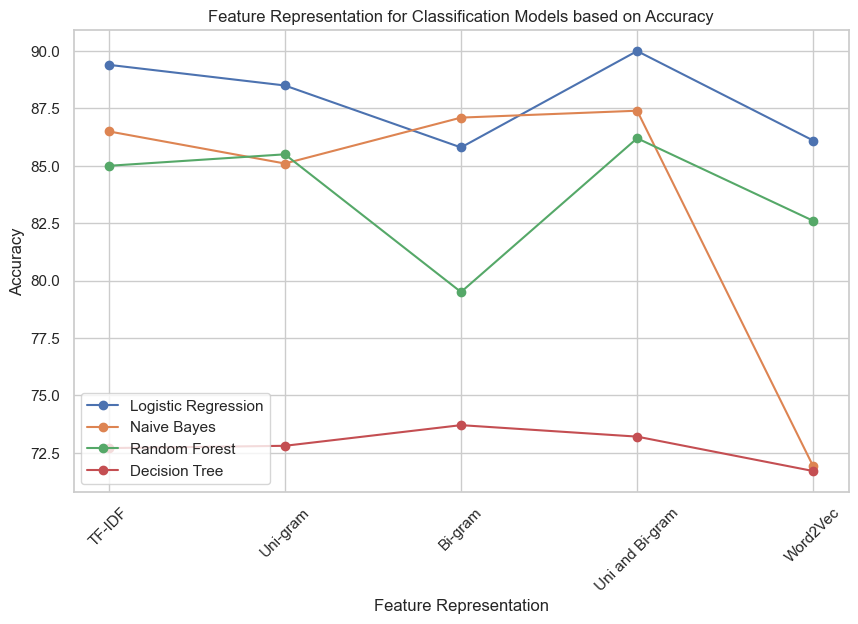

In [33]:
data = {
    'Feature Representation': ['TF-IDF', 'Uni-gram', 'Bi-gram', 'Uni and Bi-gram', 'Word2Vec'],
    'Logistic Regression': [89.4, 88.5, 85.8, 90.0, 86.1],
    'Naive Bayes': [86.5, 85.1, 87.1, 87.4, 71.9],
    'Random Forest': [85.0, 85.5, 79.5, 86.2, 82.6],
    'Decision Tree': [72.7, 72.8, 73.7, 73.2, 71.7]
}

df = pd.DataFrame(data)

sns.set(style="whitegrid") #Set plot style

#line plot
plt.figure(figsize=(10, 6))
for model in df.columns[1:]:
    plt.plot(df['Feature Representation'], df[model], marker='o', label=model)

#labels and title
plt.xlabel("Feature Representation")
plt.ylabel("Accuracy")
plt.title("Feature Representation for Classification Models based on Accuracy")

#legend
plt.legend(loc="lower left")

#Rotate x-axis labels for better readability
plt.xticks(rotation=45)

#Show plot
plt.grid(True)
plt.show()
